### Machine learning Explainability approaches 

This notebook uses Kaggle's House Prices: Advanced regression (https://www.kaggle.com/c/house-prices-advanced-regression-techniques) techniques to apply different explainability methods. 

The following will be explored: 

- Partial dependency plots (PDP)
- Indepedent conditional expectations (ICE)
- Feature importances calculated with feature permutation
- Global Surrogate models
- LIME
- Shapley values

.... later:  
    - Anchors
    - Data Shapley 

### Import and clean the data 

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from pycebox.ice import ice, ice_plot

In [143]:
data = pd.read_csv("train.csv")

In [144]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


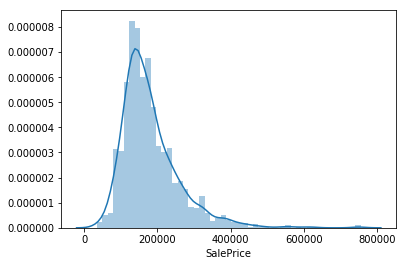

In [145]:
# Plot the target: SalePrice: It looks rather skewed, as expected: a few houses with very high prices on the right tail 
sns.distplot(data['SalePrice'])

Text(0,0.5,'SalePrice')

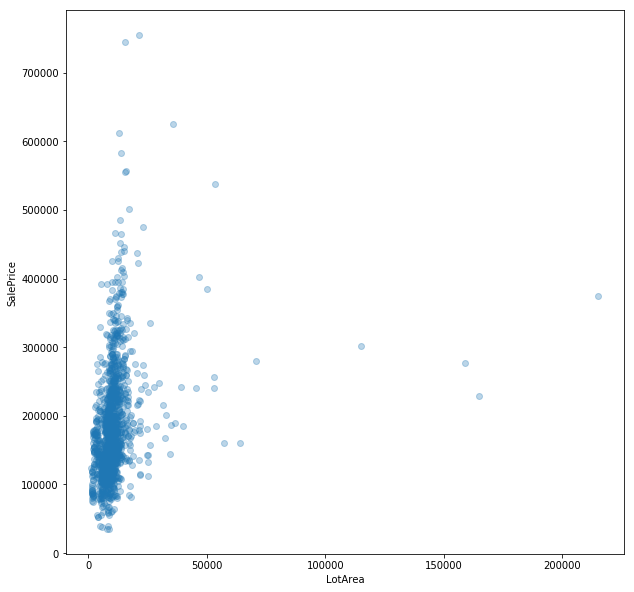

In [146]:
# Plot other features of interest and how they might move with the target: LotArea vs SalePrice
plt.figure(figsize=(10, 10))
plt.scatter(data['LotArea'], data['SalePrice'], alpha=0.3)
plt.xlabel('LotArea')
plt.ylabel('SalePrice')

Text(0,0.5,'SalePrice')

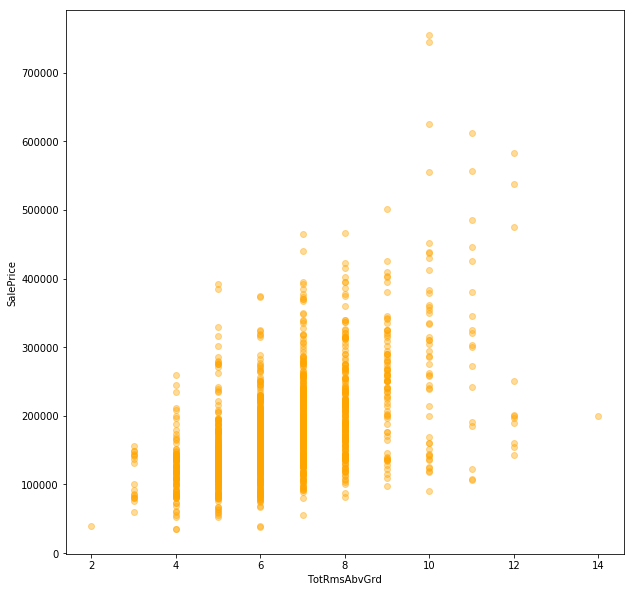

In [147]:
plt.figure(figsize=(10, 10))
plt.scatter(data['TotRmsAbvGrd'], data['SalePrice'], alpha=0.4, color='orange')
plt.xlabel('TotRmsAbvGrd')
plt.ylabel('SalePrice')

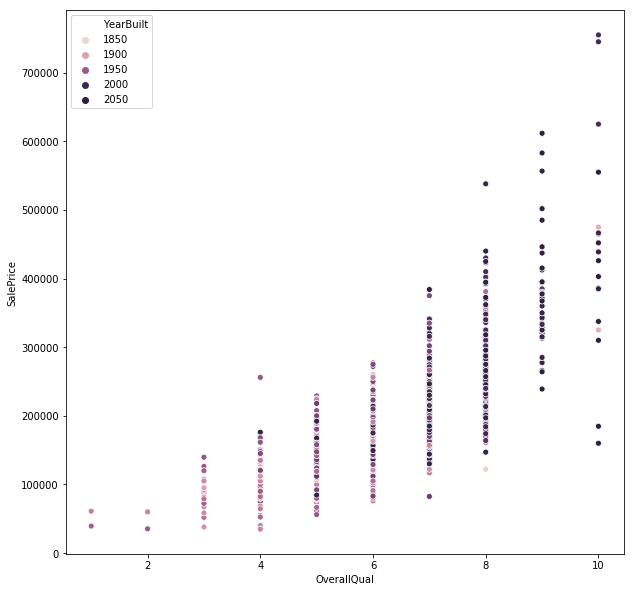

In [148]:
# Plot other features of interest and how they might move with the target: OverallQual vs SalePrice, 
# colored by the year of built 
 
plt.figure(figsize=(10, 10))
g = sns.scatterplot(x="OverallQual", y="SalePrice",
              hue="YearBuilt" ,
              data=data) 

Text(0,0.5,'SalePrice')

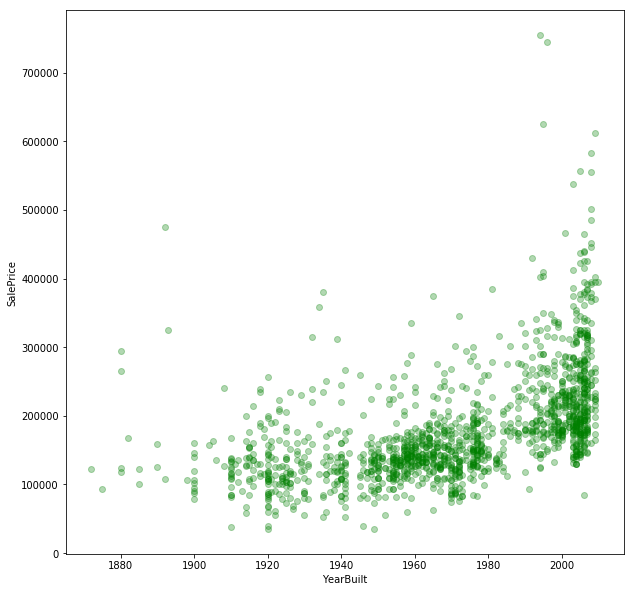

In [149]:
# Plot other features of interest and how they might move with the target: YearBuilt vs SalePrice
plt.figure(figsize=(10, 10))
plt.scatter(data['YearBuilt'], data['SalePrice'], alpha=0.3, color='green')
plt.xlabel('YearBuilt')
plt.ylabel('SalePrice')

In [150]:
np.corrcoef(data['TotRmsAbvGrd'], data['LotArea'])

array([[1.        , 0.19001478],
       [0.19001478, 1.        ]])

Text(0,0.5,'LotArea')

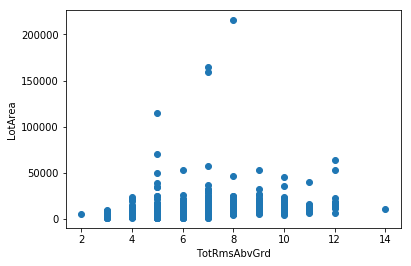

In [151]:
plt.scatter(data['TotRmsAbvGrd'], data['LotArea'])
plt.xlabel('TotRmsAbvGrd')
plt.ylabel('LotArea')

In [152]:
# drop features with many missings
data = data.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'], axis=1)

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

In [154]:
# Make ID an index
data = data.set_index('Id')

In [155]:
# Make dummies
data_dummies = pd.get_dummies(data, drop_first=True)

In [156]:
data_dummies.SaleType_New.value_counts()/len(data_dummies)

0    0.916438
1    0.083562
Name: SaleType_New, dtype: float64

In [157]:
# Fillna with 0
data_dummies = data_dummies.fillna(0)

We want to drop features with less than 5% variability, we will use VarianceThreshold for that. 

In [158]:
# Apply the VarianceThreshold function, selecting 5% as a threshold. 

selector = VarianceThreshold(threshold=0.05)
data1 = selector.fit_transform(data_dummies)
# Array of integers corresponding to non removed features
features = selector.get_support(indices=True)
# Array of all non removed features names
feature_names = [column for column in data_dummies.iloc[:, features]]
data1 = pd.DataFrame(selector.fit_transform(data_dummies), columns=feature_names) 

In [159]:
# Around half of the features drop, we ar eleft with 107 features 
print('Shape after dropping feat with low variance: ', data1.shape)
print('Shape before dropping feat with low variance: ', data_dummies.shape)

Shape after dropping feat with low variance:  (1460, 104)
Shape before dropping feat with low variance:  (1460, 233)


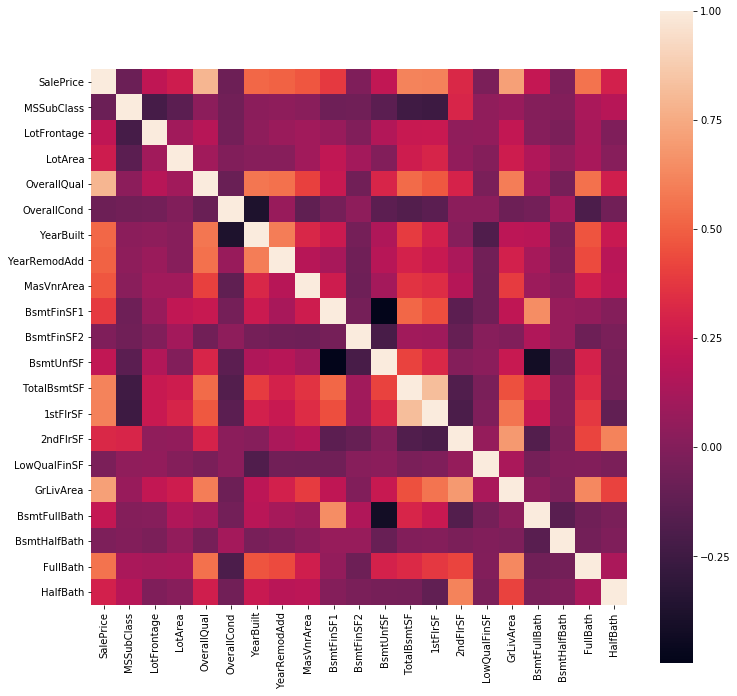

In [160]:
# plot a correlation matrix first 20 features and SalePrice

corrmat = pd.concat([data1.loc[:, 'SalePrice'] ,data1.iloc[:, :20]], axis = 1).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,  xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values, square=True)

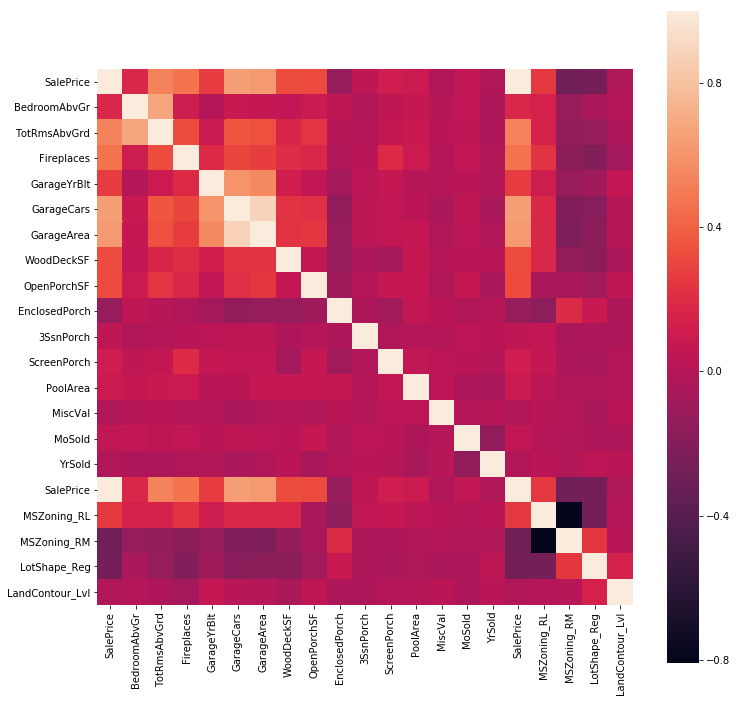

In [161]:
# plot a correlation matrix second 20 features

corrmat = pd.concat([data1.loc[:, 'SalePrice'] ,data1.iloc[:, 20:40]], axis = 1).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,  xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values, square=True)

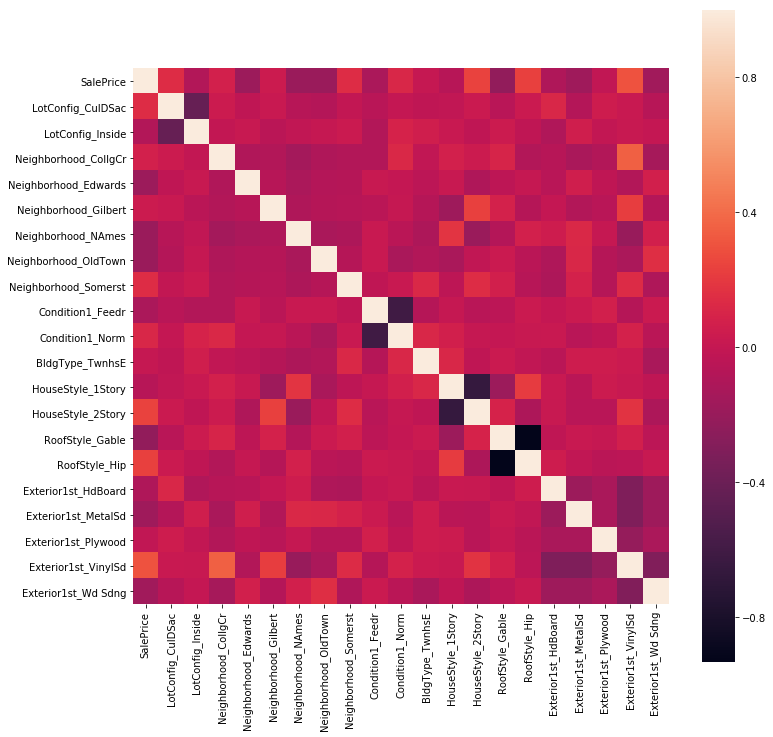

In [162]:
# plot a correlation matrix third 20 features

corrmat = pd.concat([data1.loc[:, 'SalePrice'] ,data1.iloc[:, 40:60]], axis = 1).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,  xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values, square=True)

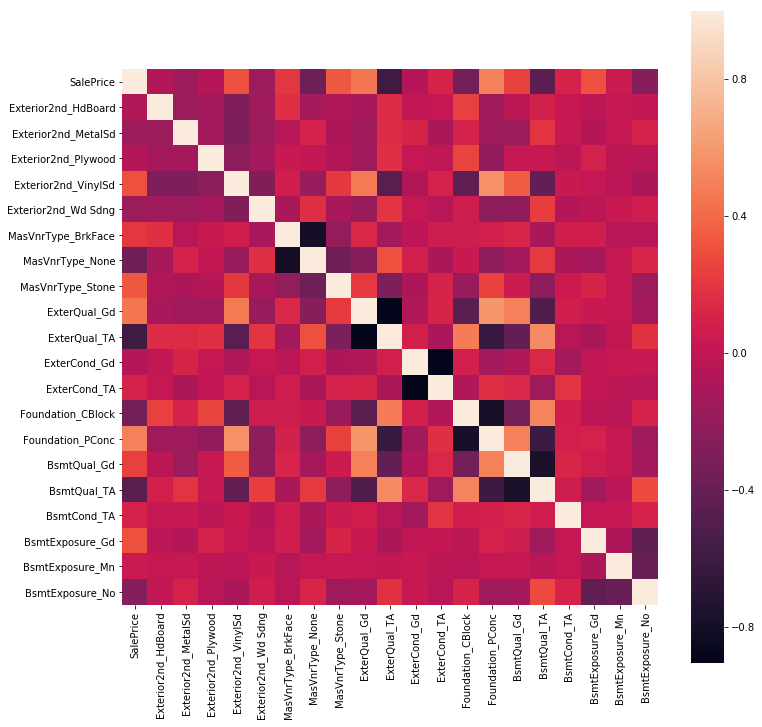

In [163]:
# plot a correlation matrix fourth 20 features

corrmat = pd.concat([data1.loc[:, 'SalePrice'] ,data1.iloc[:, 60:80]], axis = 1).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,  xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values, square=True)

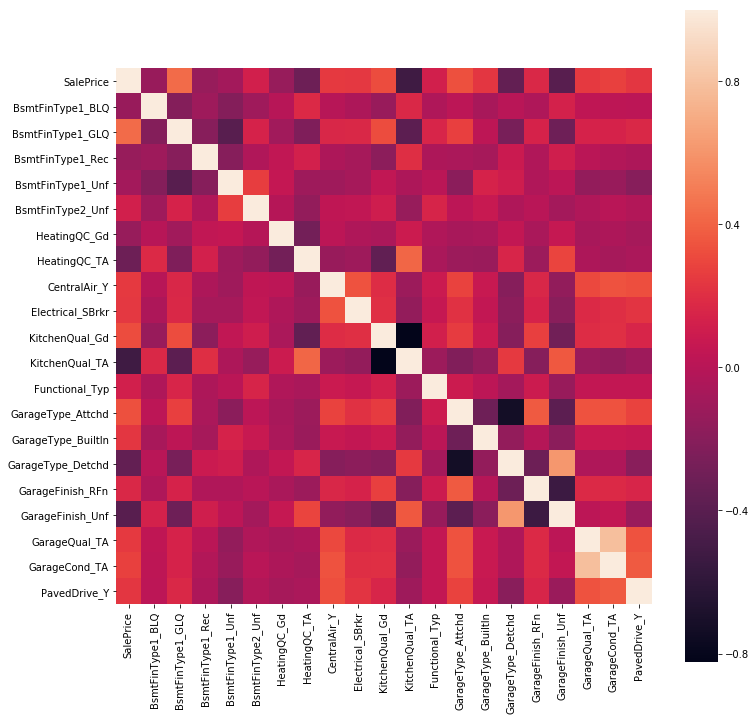

In [164]:
# plot a correlation matrix fifth 20 features

corrmat = pd.concat([data1.loc[:, 'SalePrice'] ,data1.iloc[:, 80:100]], axis = 1).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,  xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values, square=True)

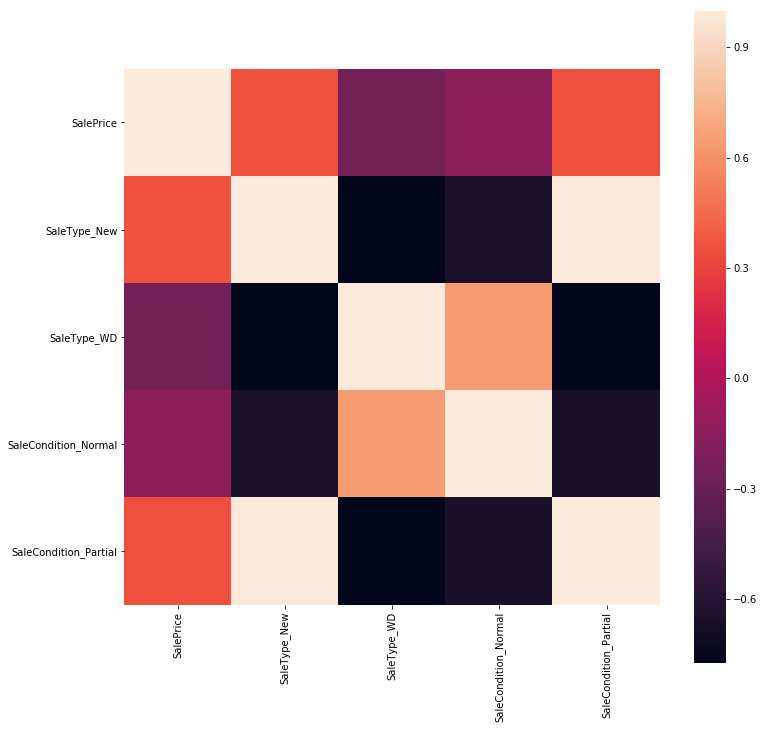

In [165]:
# plot a correlation matrix fifth 20 features

corrmat = pd.concat([data1.loc[:, 'SalePrice'] ,data1.iloc[:, 100:]], axis = 1).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,  xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values, square=True)

In [166]:
# Define X and y matrices

y = data1.SalePrice
X = data1.drop('SalePrice', axis=1)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_TA,GarageCond_TA,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Normal,SaleCondition_Partial
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0


In [167]:
for col in X.columns:
    print(col)

MSSubClass
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
MSZoning_RL
MSZoning_RM
LotShape_Reg
LandContour_Lvl
LotConfig_CulDSac
LotConfig_Inside
Neighborhood_CollgCr
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_NAmes
Neighborhood_OldTown
Neighborhood_Somerst
Condition1_Feedr
Condition1_Norm
BldgType_TwnhsE
HouseStyle_1Story
HouseStyle_2Story
RoofStyle_Gable
RoofStyle_Hip
Exterior1st_HdBoard
Exterior1st_MetalSd
Exterior1st_Plywood
Exterior1st_VinylSd
Exterior1st_Wd Sdng
Exterior2nd_HdBoard
Exterior2nd_MetalSd
Exterior2nd_Plywood
Exterior2nd_VinylSd
Exterior2nd_Wd Sdng
MasVnrType_BrkFace
MasVnrType_None
MasVnrType_Stone
ExterQual_Gd
ExterQual_TA
ExterCond_Gd
Ext